# Make figure showing both models and all algos (with and without skin)

In [13]:
!mamba install aerobulk-python -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['aerobulk-python']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ╸━━━━━━━━━━━━━━━╸━━━━━━   0.0 B /  ??.?

In [1]:
from aerobulk import skin, noskin

# CM2.6

Compute small scales for single time step of CM2.6 data

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs
from dask.diagnostics import ProgressBar
from intake import open_catalog
import xesmf as xe

# 👇 replace with your key 
with open('/home/jovyan/scale-aware-air-sea/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
subfolder_full = 'ocean-transport-group/scale-aware-air-sea/outputs/temp/'
subfolder_final = 'ocean-transport-group/scale-aware-air-sea/outputs/'

In [4]:
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)
# adjust chunks
ds_atmos = ds_atmos.chunk({'time':1})

Load the single timesteps to speed up computation

In [6]:
%time ds_atmos_loaded = ds_atmos.isel(time=0).load()

CPU times: user 7.67 s, sys: 3.91 s, total: 11.6 s
Wall time: 8.57 s


In [7]:
%time ds_ocean_loaded = ds_ocean.isel(time=0).load()

CPU times: user 1.26 s, sys: 1.08 s, total: 2.34 s
Wall time: 908 ms


👆This seems to be suspiciously fast to load in a single ocean time step. Why does this take way shorter than the atmosphere, which is a smaller dataset (at a single time step)?

In [10]:
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 7305, grid_xt: 576, grid_yt: 360, bnds: 2)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 0.0 0.625 0.625 ... 359.4 359.4 360.0
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [11]:
ds_ocean

<xarray.Dataset>
Dimensions:         (time: 7305, nv: 2, st_ocean_sub01: 1, xt_ocean: 3600,
                     xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * time            (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * nv              (nv) float64 1.0 2.0
  * st_ocean_sub01  (st_ocean_sub01) float64 5.034
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables: (12/14)
    biomass_p       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    chl             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    dic             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    htotal          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    irr_mix         (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    kw              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...              ...
    sea_level       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sea_level_sq    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_salt    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    usurf           (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    vsurf           (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_minibling_surf_field.nc
    grid_tile:  1
    grid_type:  mosaic
    history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
    title:      CM2.6_miniBling

## Regridding the atmos variables onto the ocean grid

In [12]:
fs = gcsfs.GCSFileSystem(token=token)
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr'
mapper = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper).load()
regridder = xe.Regridder(
    ds_atmos.olr.to_dataset(name='dummy').isel(time=0),
    ds_ocean.surface_temp.to_dataset(name='dummy').isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [13]:
ds_atmos_regridded = regridder(ds_atmos_loaded[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref', 'wind', 'swdn_sfc', 'lwdn_sfc']]) 
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean_loaded[['surface_temp']],
    ]
)

### Create function for each variable and algorithm

#### Without skin

In [14]:
def noskin_ds_wrapper_cm26(ds_in, algo, **kwargs):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.surface_temp + 273.15
    t_zt = ds_in.t_ref
    hum_zt = ds_in.q_ref
    u_zu = ds_in.u_ref
    v_zu = ds_in.v_ref
    slp = ds_in.slp * 100 # check this
    
    ql, qh, taux, tauy, evap =  noskin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        **kwargs
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    return ds_out

In [15]:
def run_results_noskin_cm26(algo,var):

    # Compute air-sea fluxes on the full field
    ds_out = noskin_ds_wrapper_cm26(ds_merged, algo, input_range_check=True)
    
    # Merge together original variables and air-sea fluxes computed on full fields
    ds = xr.merge([ds_merged, ds_out], join='inner')
    ds = ds.assign_coords(area=ds_oc_grid.area_t)
    
    coarsen_win = dict(xt_ocean=20, yt_ocean=20)
    mean_dims = ['xt_ocean', 'yt_ocean']
    
    # Create land mask
    masked_area = ds.area.where(~np.isnan(ds.surface_temp)) #.isel(time=0)))
    ds_weighted = ds * masked_area
    
    # Coarsen the air-sea fluxes + original input variables (by first coarsening the mask, then the masked array)
    coarsened_area = masked_area.coarsen(**coarsen_win).sum(mean_dims) #.drop_vars(['time'])
    ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / coarsened_area
    # Add coarsened mask to coords
    ds_coarsened = ds_coarsened.assign_coords(area=coarsened_area)
    
    # Apply a new (strict) landmask to fields that had nans in them before <-- why is this needed?
    coarsened_landmask = np.isnan(ds['surface_temp']).coarsen(**coarsen_win).sum(mean_dims)>0 # .mean('time')
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
    
    # Compute air-sea fluxes with coarsened input
    ds_recompute_coarse = noskin_ds_wrapper_cm26(ds_coarsened, algo, input_range_check=False)
    # add all the recomputed variables from coarsened ouput back to the input dataset
    ds_coarsened[var+'_large_scale'] = ds_recompute_coarse[var]
    
    return ds_coarsened

In [16]:
%%time
var = 'ql'
output_cm26_ecmwf = run_results_noskin_cm26('ecmwf',var)
output_cm26_ncar = run_results_noskin_cm26('ncar',var)
output_cm26_coare3p6 = run_results_noskin_cm26('coare3p6',var)
output_cm26_andreas = run_results_noskin_cm26('andreas',var)

/srv/conda/envs/notebook/lib/python3.9/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  wa

CPU times: user 1min 43s, sys: 6.51 s, total: 1min 50s
Wall time: 1min 51s


#### With skin

In [18]:
def skin_ds_wrapper_cm26(ds_in, algo, **kwargs):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.surface_temp + 273.15
    t_zt = ds_in.t_ref
    hum_zt = ds_in.q_ref
    u_zu = ds_in.u_ref
    v_zu = ds_in.v_ref
    slp = ds_in.slp * 100 # check this
    rad_sw = ds_in.swdn_sfc
    rad_lw = ds_in.lwdn_sfc
    
    ql, qh, taux, tauy, t_s, evap =  skin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp,
        rad_sw,
        rad_lw,
        algo=algo,
        zt=2,
        zu=10,
        **kwargs
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    ds_out['t_s'] = t_s
    return ds_out

In [19]:
def run_results_skin_cm26(algo,var):

    ds_out = skin_ds_wrapper_cm26(ds_merged, algo, input_range_check=False)
    
    ds = xr.merge([ds_merged, ds_out], join='inner')
    ds = ds.assign_coords(area=ds_oc_grid.area_t)#.load()
    
    coarsen_win = dict(xt_ocean=20, yt_ocean=20)
    mean_dims = ['xt_ocean', 'yt_ocean']
    
    masked_area = ds.area.where(~np.isnan(ds.surface_temp)) #.isel(time=0)))
    ds_weighted = ds * masked_area
    coarsened_area = masked_area.coarsen(**coarsen_win).sum(mean_dims) #.drop_vars(['time'])#.squeeze(drop=True)# This does not work. Annoying!
    ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / coarsened_area
    # add area t
    ds_coarsened = ds_coarsened.assign_coords(area=coarsened_area)
    
    
    # Apply a new (strict) landmask to fields that had nans in them before
    coarsened_landmask = coarsened_landmask = np.isnan(ds['surface_temp']).coarsen(**coarsen_win).sum(mean_dims)>0 # .mean('time')
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
    ds_coarsened
    
    ds_recompute_coarse = skin_ds_wrapper_cm26(ds_coarsened, algo, input_range_check=False)
    # add all the recomputed variables from coarsened ouput back to the input dataset
    ds_coarsened[var+'_large_scale'] = ds_recompute_coarse[var]
    
    return ds_coarsened

In [20]:
%%time
var = 'ql'
output_cm26_ecmwf_skin = run_results_skin_cm26('ecmwf',var)
output_cm26_coare3p6_skin = run_results_skin_cm26('coare3p6',var)

CPU times: user 2min 39s, sys: 2.08 s, total: 2min 41s
Wall time: 2min 41s


## CESM data

Compute the single timesteps for the CESM data

In [21]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds_ocean  = cat["CESM_POP_hires_control"].to_dask()

In [22]:
import fsspec
import xarray as xr

dataset_public_url = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge-test/prod/recipe-run-502/pangeo-forge/cesm-atm-025deg-feedstock/cesm-atm-025deg.zarr'
mapper = fsspec.get_mapper(dataset_public_url)
ds_atmos = xr.open_zarr(mapper, consolidated=True)

In [23]:
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)
# instead do this
#ds_atmos = ds_atmos.chunk({'time':1})

In [24]:
ds_ocean = ds_ocean.isel(time=0)

In [25]:
ds_atmos = ds_atmos.isel(time=0)

## Regridding the atmos variables onto the ocean grid

Load previously computed regridding weights to move from atmos to ocean grid

In [26]:
atmos_grid = ds_atmos #.isel(time=0)
ocean_grid = ds_ocean.drop_vars([co for co in ds_ocean.coords if co not in ['TLONG','TLAT']]) #.isel(time=0)

In [27]:
import xesmf as xe
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/ncar_atmos2ocean.zarr'
mapper_regrid = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper_regrid).load()
regridder = xe.Regridder(
    atmos_grid,
    ocean_grid,
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
#regridder

In [28]:
ds_atmos_regridded = regridder(ds_atmos[['TS', 'UBOT', 'VBOT', 'QREFHT', 'PSL','TREFHT','FSNS','FLDS']])
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded, #.chunk({'time':1}), # to have more manageable sized chunks (same as ocean variables)
        ds_ocean[['SST']] #.chunk({'time':73}), # to have same chunksizes as atmospheric variables
    ]
)

In [29]:
%%time
# Try loading in ds_test (~=1.8GB) to memory
ds_test_loaded = ds_merged.load()
ds_test_loaded

CPU times: user 18.5 s, sys: 17.3 s, total: 35.9 s
Wall time: 9.75 s


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600)
Coordinates: (12/52)
    time                object 0078-01-01 00:00:00
    TLONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TLAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ANGLE               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ANGLET              (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    DXT                 (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ...                  ...
    salt_to_ppt         float64 0.0
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TS                  (nlat, nlon) float32 299.7 299.7 299.7 ... 299.7 299.7
    UBOT                (nlat, nlon) float32 0.4175 0.4175 ... 0.4175 0.4175
    VBOT                (nlat, nlon) float32 5.057 5.057 5.057 ... 5.057 5.057
    QREFHT              (nlat, nlon) float32 0.01648 0.01648 ... 0.01648 0.01648
    PSL                 (nlat, nlon) float32 1.015e+05 1.015e+05 ... 1.015e+05
    TREFHT              (nlat, nlon) float32 298.9 298.9 298.9 ... 298.9 298.9
    FSNS                (nlat, nlon) float32 221.8 221.8 221.8 ... 221.8 221.8
    FLDS                (nlat, nlon) float32 417.9 417.9 417.9 ... 417.9 417.9
    SST                 (nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

### Create functions for each algo and var

#### Without skin

In [30]:
def noskin_ds_wrapper(ds_in, algo, **kwargs):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.SST + 273.15 #.where(ds_in.SST > (270-273.15)).where(ds_in.SST < (320-273.15)) + 273.15 # K (need to convert from degC to K!)
    t_zt = ds_in.TREFHT #TS # K
    hum_zt = ds_in.QREFHT # kg/kg
    u_zu = ds_in.UBOT #.where(ds_in.UBOT < 25).where(ds_in.UBOT > -25) # m/s
    v_zu = ds_in.VBOT #.where(ds_in.VBOT < 25).where(ds_in.VBOT > -25) # m/s
    slp = ds_in.PSL # Pa #* 100 <-- needed for CM2.6 data
    zu = 55
    zt = 2
    
    ql, qh, taux, tauy, evap =  noskin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp=slp,
        algo=algo,
        zt=zt, # height at which air temperature and humidity are measured
        zu=zu, # height at which u,v fields are measured
        **kwargs
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    return ds_out

In [31]:
# Try to run for numerous algos and then concatenate together
def run_results_noskin(algo,var):
    # Compute (lazily) the noskin function of Aerobulk
    #algo = 'ecmwf'
    
    ds_out = noskin_ds_wrapper(ds_test_loaded, algo, input_range_check=False)
    
    # combine all variables (input + flux output + area) in one dataset. 
    ds = xr.merge([ds_merged, ds_out], join='inner')
    
    coarsen_win = dict(nlon=20, nlat=20)
    mean_dims = ['nlon', 'nlat']
    
    
    masked_area = ds.TAREA.where(~np.isnan(ds.SST)) # / (100**2) # convert from cm^2 to m^2
    ds_weighted = ds * masked_area
    coarsened_area = masked_area.coarsen(**coarsen_win).sum(mean_dims).drop_vars(['time'])#.squeeze(drop=True)# This does not work. Annoying!
    ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / coarsened_area
    # add area t
    ds_coarsened = ds_coarsened.assign_coords(area=coarsened_area)
    
    
    # Apply a new (strict) landmask to fields that had nans in them before
    coarsened_landmask = np.isnan(ds['SST']).coarsen(**coarsen_win).sum(mean_dims)>0
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
    
    ds_recompute_coarse = noskin_ds_wrapper(ds_coarsened, algo, input_range_check=False)
    # add all the recomputed variables from coarsened ouput back to the input dataset
    for var in ds_recompute_coarse.data_vars:
        ds_coarsened[var+'_large_scale'] = ds_recompute_coarse[var]
    return ds_coarsened

In [32]:
%%time
var = 'ql'
output_ecmwf = run_results_noskin('ecmwf',var)
output_ncar = run_results_noskin('ncar',var)
output_coare3p6 = run_results_noskin('coare3p6',var)
output_andreas = run_results_noskin('andreas',var)

CPU times: user 1min 45s, sys: 9.89 s, total: 1min 55s
Wall time: 1min 55s


#### With skin

In [33]:
def skin_ds_wrapper(ds_in, algo, **kwargs):
    ds_out = xr.Dataset()
    #ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.SST + 273.15 #.where(ds_in.SST > (270-273.15)).where(ds_in.SST < (320-273.15)) + 273.15 # K (need to convert from degC to K!)
    t_zt = ds_in.TREFHT #TS # K
    hum_zt = ds_in.QREFHT # kg/kg
    u_zu = ds_in.UBOT #.where(ds_in.UBOT < 25).where(ds_in.UBOT > -25) # m/s
    v_zu = ds_in.VBOT #.where(ds_in.VBOT < 25).where(ds_in.VBOT > -25) # m/s
    slp = ds_in.PSL # Pa #* 100 <-- needed for CM2.6 data
    rad_sw = ds_in.FSNS
    rad_lw = ds_in.FLDS
    zu = 55
    zt = 2
    
    ql, qh, taux, tauy, t_s, evap =  skin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp,
        rad_sw,
        rad_lw,
        algo=algo,
        zt=zt, # height at which air temperature and humidity are measured
        zu=zu, # height at which u,v fields are measured
        input_range_check=False
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    ds_out['t_s'] = t_s
    return ds_out

In [34]:
# Try to run for numerous algos and then concatenate together
def run_results_skin(algo,var):
    
    ds_out = skin_ds_wrapper(ds_test_loaded, algo, input_range_check=False)
    print('ds_out defined')
    
    # combine all variables (input + flux output + area) in one dataset
    ds = xr.merge([ds_merged, ds_out], join='inner')
    print('ds merged')      
    
    coarsen_win = dict(nlon=20, nlat=20)
    mean_dims = ['nlon', 'nlat']
    
    
    masked_area = ds.TAREA.where(~np.isnan(ds.SST)) # / (100**2) # convert from cm^2 to m^2
    print('masked_area defined')
    ds_weighted = ds * masked_area
    coarsened_area = masked_area.coarsen(**coarsen_win).sum(mean_dims) #.drop_vars(['time'])#.squeeze(drop=True)# This does not work. Annoying!
    ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / coarsened_area
    # add area t
    ds_coarsened = ds_coarsened.assign_coords(area=coarsened_area)
    print('ds_coarsened defined')
    
    
    # Apply a new (strict) landmask to fields that had nans in them before
    coarsened_landmask = np.isnan(ds['SST']).coarsen(**coarsen_win).sum(mean_dims)>0
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
    print('ds_coarsened masked')
    
    ds_recompute_coarse = skin_ds_wrapper(ds_coarsened, algo, input_range_check=False)
    # add all the recomputed variables from coarsened ouput back to the input dataset
    for var in ds_recompute_coarse.data_vars:
        ds_coarsened[var+'_large_scale'] = ds_recompute_coarse[var]
    return ds_coarsened

In [35]:
%%time
var = 'ql'
output_ecmwf_skin = run_results_skin('ecmwf',var)
output_coare3p6_skin = run_results_skin('coare3p6',var)

ds_out defined
ds merged
masked_area defined
ds_coarsened defined
ds_coarsened masked
ds_out defined
ds merged
masked_area defined
ds_coarsened defined
ds_coarsened masked
CPU times: user 2min 32s, sys: 4.83 s, total: 2min 36s
Wall time: 2min 36s


# Plot all together

In [36]:
pip install cmocean

Note: you may need to restart the kernel to use updated packages.


In [37]:
import cmocean

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value enco

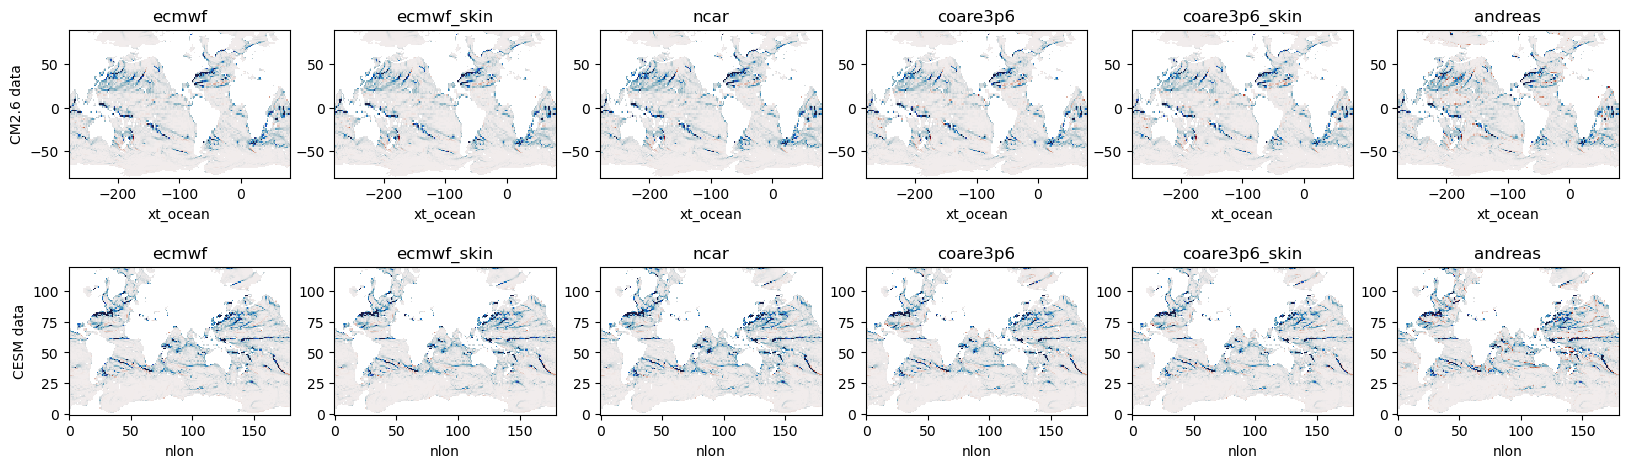

In [38]:
i = 1

plt.figure(figsize=(20,5))
for algo in ['ecmwf','ecmwf_skin','ncar','coare3p6','coare3p6_skin','andreas']:
    if algo == 'ecmwf':
        ds_output_cm26 = output_cm26_ecmwf
        ds_output = output_ecmwf
    if algo == 'ncar':
        ds_output_cm26 = output_cm26_ncar
        ds_output = output_ncar
    if algo == 'ecmwf_skin':
        ds_output_cm26 = output_cm26_ecmwf_skin
        ds_output = output_ecmwf_skin
    if algo == 'coare3p6':
        ds_output_cm26 = output_cm26_coare3p6
        ds_output = output_coare3p6
    if algo == 'coare3p6_skin':
        ds_output_cm26 = output_cm26_coare3p6_skin
        ds_output = output_coare3p6_skin
    if algo == 'andreas':
        ds_output_cm26 = output_cm26_andreas
        ds_output = output_andreas
        
    # CM2.6 data
    full_cm26 = ds_output_cm26[var] #.load() #.mean('time')
    large_scale_cm26 = ds_output_cm26[var+'_large_scale'] #.load() # .mean('time')
    small_scale_cm26 = full_cm26-large_scale_cm26
    
    # CESM data
    full = ds_output[var] #.load() #.mean('time')
    large_scale = ds_output[var+'_large_scale'] #.load() # .mean('time')
    small_scale = full-large_scale

    # not quite sure if we should look at the mean of the difference or the difference of the mean over time...
    plot_kwargs = {'y':'yt_ocean', 'center':0, 'vmin':-10, 'vmax':10, 'cmap':cmocean.cm.balance, 'add_colorbar':False}
    plt.subplot(2,6,i)
    small_scale_cm26.plot(**plot_kwargs)
    plt.title(algo)
    if i == 1:
        plt.ylabel('CM2.6 data')
    else:
        plt.ylabel('')
    
    plot_kwargs = {'y':'nlat', 'center':0, 'vmin':-10, 'vmax':10, 'cmap':cmocean.cm.balance, 'add_colorbar':False}
    plt.subplot(2,6,i+6)
    small_scale.plot(**plot_kwargs)
    plt.title(algo)
    if i == 1:
        plt.ylabel('CESM data')
    else:
        plt.ylabel('')
    i+=1
    
    plt.subplots_adjust(hspace=0.6)

# Plot differences between individual plots

This is to verify that the plots above are indeed different

In [39]:
def plot_2var(ds1,ds2):

    full_cm26 = ds1[var] #.load() #.mean('time')
    large_scale_cm26 = ds1[var+'_large_scale'] #.load() # .mean('time')
    small_scale1 = full_cm26-large_scale_cm26

    full_cm26 = ds2[var] #.load() #.mean('time')
    large_scale_cm26 = ds2[var+'_large_scale'] #.load() # .mean('time')
    small_scale2 = full_cm26-large_scale_cm26
    
    return small_scale1,small_scale2

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'CM2.6 ql ecmwf-ncar')

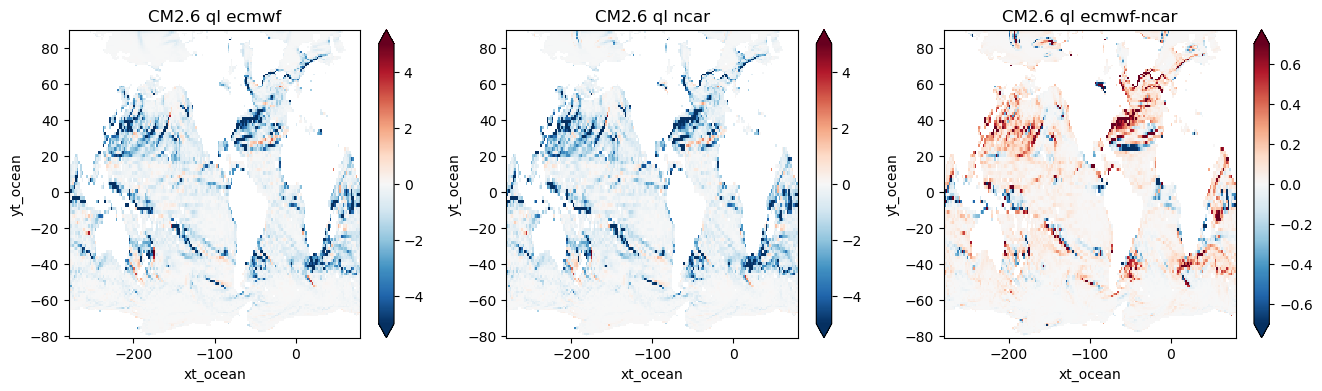

In [40]:
s1,s2 = plot_2var(output_cm26_ecmwf,output_cm26_ncar)

plt.figure(figsize=(16,4))

plt.subplot(131)
s1.plot(vmax=5)
plt.title(f'CM2.6 {var} ecmwf')

plt.subplot(132)
s2.plot(vmax=5)
plt.title(f'CM2.6 {var} ncar')

plt.subplot(133)
(s1-s2).plot(vmax=0.7)
plt.title(f'CM2.6 {var} ecmwf-ncar')

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'CM2.6 ql ecmwf-ecmwf_skin')

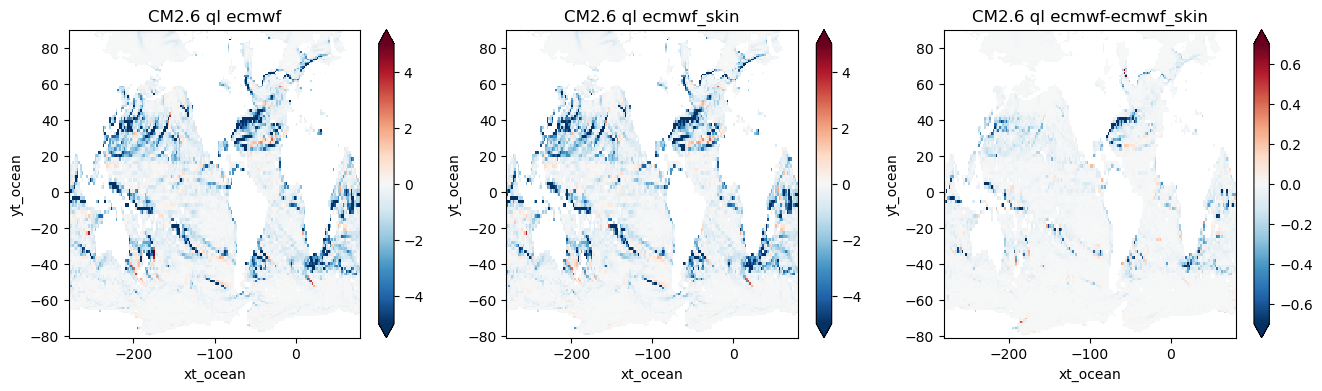

In [41]:
s1,s2 = plot_2var(output_cm26_ecmwf,output_cm26_ecmwf_skin)

plt.figure(figsize=(16,4))

plt.subplot(131)
s1.plot(vmax=5)
plt.title(f'CM2.6 {var} ecmwf')

plt.subplot(132)
s2.plot(vmax=5)
plt.title(f'CM2.6 {var} ecmwf_skin')

plt.subplot(133)
(s1-s2).plot(vmax=0.7)
plt.title(f'CM2.6 {var} ecmwf-ecmwf_skin')